In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import structure_model_lib 
import dp_modeling_lib
import data_utils

import paragami

import optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [4]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

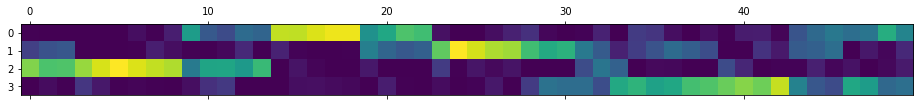

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = n_pop

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 3) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 3) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = opt_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict)

In [12]:
# take a look at init 
e_ind_admix = dp_modeling_lib.get_e_cluster_probabilities(
                    vb_params_dict['ind_mix_stick_propn_mean'], 
                    vb_params_dict['ind_mix_stick_propn_info'],
                    gh_loc, gh_weights)

e_pop_freq = dp_modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [13]:
perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)

e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

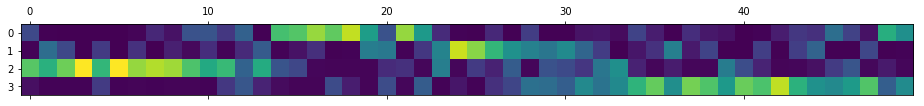

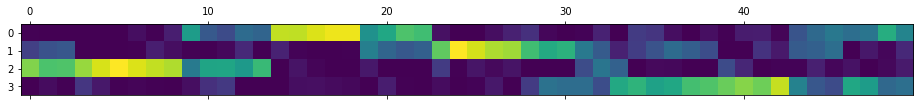

In [14]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Set up model

In [15]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights, 
                                      true_pop_allele_freq = None, 
                                      true_ind_admix_propn = None)

In [16]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict, free = True)

In [17]:
structure_model_lib.get_kl(g_obs, vb_params_dict,
                   prior_params_dict, gh_loc, gh_weights)

5278.532804627066

In [18]:
get_free_vb_params_loss_cached(init_vb_free_params)

5278.532804627066

In [19]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 50, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = 5278.53280463
Iter 1: f = 5090.16881964
Iter 2: f = 4811.52285237
Iter 3: f = 4371.95372216
Iter 4: f = 3957.89086637
Iter 5: f = 3686.31815002
Iter 6: f = 3476.78734549
Iter 7: f = 3398.62470542
Iter 8: f = 3322.20253975
Iter 9: f = 3279.05381038
Iter 10: f = 3246.53826724
Iter 11: f = 3212.94761317
Iter 12: f = 3188.52480405
Iter 13: f = 3169.61136875
Iter 14: f = 3155.53109695
Iter 15: f = 3142.20584773
Iter 16: f = 3128.94437564
Iter 17: f = 3121.70687488
Iter 18: f = 3111.71129092
Iter 19: f = 3099.97351407
Iter 20: f = 3093.69074255
Iter 21: f = 3085.81978002
Iter 22: f = 3080.33470928
Iter 23: f = 3072.10977800
Iter 24: f = 3065.50443430
Iter 25: f = 3064.53344856
Iter 26: f = 3070.20199586
Iter 27: f = 3061.67972474
Iter 28: f = 3057.11637487
Iter 29: f = 3052.46468589
Iter 30: f = 3045.63951030
Iter 31: f = 3045.82531021
Iter 32: f = 3041.14171365
Iter 33: f = 3043.15322033
Iter 34: f = 3039.35625892
Iter 35: f = 3036.78947836
Iter 36: f = 3033.95

In [18]:
vb_opt_dict = vb_params_paragami.fold(vb_opt_free_params, free=True)

In [19]:
ind_mix_stick_propn_mean = vb_opt_dict['ind_mix_stick_propn_mean']
ind_mix_stick_propn_info = vb_opt_dict['ind_mix_stick_propn_info']
pop_freq_beta_params = vb_opt_dict['pop_freq_beta_params']

In [20]:
e_pop_allele_freq = pop_freq_beta_params[:, :, 0] / pop_freq_beta_params.sum(axis=2)

In [21]:
def find_min_perm(x, y, axis = 0):
    # perumutes array x along axis to find closest 
    # match to y
        
    perms = list(permutations(np.arange(x.shape[axis])))

    i = 0
    diff_best = np.Inf
    for perm in perms: 

        x_perm = x.take(perm, axis)
        
        diff = np.sum((x_perm - y)**2)
        
        if diff < diff_best: 
            diff_best = diff
            i_best = i
        
        i += 1

    return perms[i_best]

In [22]:
perm_best = find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)

([array([5., 5., 5., 4., 4., 3., 2., 2., 4., 6.]),
  array([5., 4., 3., 4., 3., 3., 1., 5., 6., 6.]),
  array([6., 5., 2., 6., 3., 3., 3., 1., 2., 9.]),
  array([4., 4., 5., 2., 2., 5., 4., 1., 5., 8.])],
 array([0.04343313, 0.13525268, 0.22707223, 0.31889178, 0.41071133,
        0.50253088, 0.59435043, 0.68616998, 0.77798953, 0.86980908,
        0.96162863]),
 <a list of 4 Lists of Patches objects>)

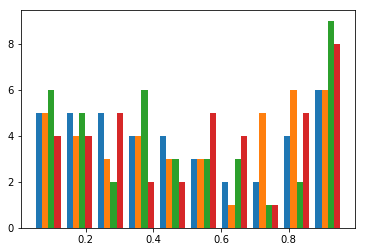

In [24]:
plt.hist(e_pop_allele_freq)

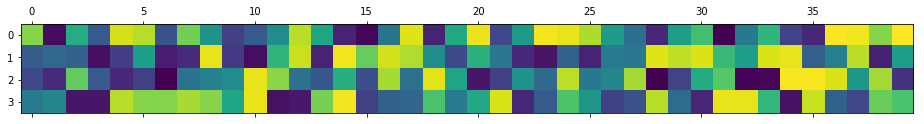

In [25]:
plt.matshow(e_pop_allele_freq[:, perm_best].T)

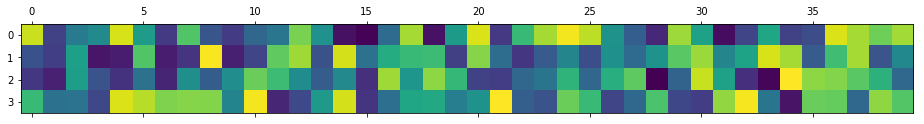

In [26]:
plt.matshow(true_pop_allele_freq.T)

In [27]:
e_ind_admix = dp_modeling_lib.get_e_cluster_probabilities(
                        ind_mix_stick_propn_mean, ind_mix_stick_propn_info,
                        gh_loc, gh_weights)[:, perm_best]

In [28]:
e_ind_admix.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3,
       0, 0, 3, 3, 0, 0])

In [29]:
true_ind_admix_propn.argmax(axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 3, 3, 0, 0])

In [30]:
np.mean(e_ind_admix.argmax(axis=1) == \
       true_ind_admix_propn.argmax(axis=1))

0.86

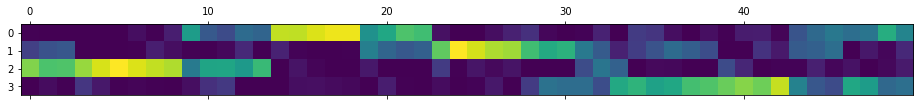

In [31]:
plt.matshow(true_ind_admix_propn.T)

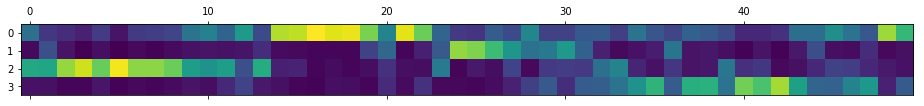

In [32]:
plt.matshow(e_ind_admix.T)

# Parametric sensitivity

In [80]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [85]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights),
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        hessian_at_opt=None,
        cross_hess_at_opt=None,
        factorize_hessian=True,
        hyper_par_objective_fun=None,
        grad_tol=1e-8)

In [89]:
from copy import deepcopy

In [93]:
prior_pertubed_dict = deepcopy(prior_params_dict)

In [95]:
prior_pertubed_dict['dp_prior_alpha'] = 2.

In [99]:
comb_params_free_lin = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_pertubed_dict, free = True))

In [100]:
comb_params_free_lin

array([ 2.32172869,  3.1755255 ,  2.50343521,  2.62712103,  1.87852926,
        2.48471785,  3.23683328,  1.74602559,  1.57487065,  3.35751582,
        2.37435174,  2.7247483 ,  1.78007079,  2.52603034,  0.92795952,
        3.37493289,  3.18862689,  2.30681577,  0.94742414,  3.16414208,
        1.90627823,  2.44647676,  2.99476692,  2.38653228,  2.26595368,
        3.17310252,  0.95651658,  3.17348999,  0.39309414,  2.85619964,
        2.34362951,  3.00783546,  1.96703542,  3.25978503,  3.17782299,
        1.08286331,  1.54319084,  2.59228123,  3.36510791,  1.04443013,
        2.27611268,  3.17024466,  3.0721551 ,  1.60907456,  2.40047123,
        1.99638217,  3.30951611,  1.40650398,  0.30330877,  3.5165531 ,
        2.95229939,  1.8688245 ,  0.76697014,  2.80541818,  2.24553039,
        3.03433617,  2.69527868,  2.96043076,  3.09154079,  1.44310511,
        1.10723315,  2.7311008 ,  3.18806248,  1.88817014,  2.73252521,
        2.89807093,  3.00965834,  1.66738311,  2.95236768,  0.24